In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [5]:
data = pd.read_csv('Data/Cleaned_data.csv')
combinations = data[['visualiseringskode', 'station']].drop_duplicates().values

# Errors

In [87]:
def error_plot(errors_dataframe):
    bar_width = 0.25
    index = range(len(errors_dataframe))

    plt.bar(index, errors_dataframe['Error_arima'], bar_width, label='ARIMA')
    plt.bar([i + bar_width for i in index], errors_dataframe['Error_full'], bar_width, label='Full')

    plt.xlabel('(Strækning, Station)')
    plt.ylabel('Error')
    plt.title('Error comparison for (Strækning, Station) pairs')
    plt.xticks([i + bar_width / 2 for i in index], [pair for pair in errors_dataframe['Strækning/station']])
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.grid()
    plt.show()

def filter_errors(errors_dataframe, strækning):
    # Filter DataFrame for rows where the first number in "Strækning/station" is 20
    filtered_df = errors_dataframe[errors_dataframe['Strækning/station'].apply(lambda x: int(x.split(',')[0].strip()[1:]) == strækning)]
    return filtered_df
    # x = np.arange(errors_dataframe.shape[0])
    # width = 0.25  # the width of the bars
    # multiplier = 0

    # fig, ax = plt.subplots(layout='constrained')

    # for strækning_station, error_arima, error_full in errors_dataframe.values:
    #     offset = width * multiplier
    #     rects = ax.bar(x + offset, error_arima, width, label=strækning_station)
    #     multiplier += 1
    # ax.legend(loc='upper left', ncols=2)
    # ax.set_xticks(x + width, combinations)
    # ax.set_xlabel('[Strækning, Station]')
    # ax.set_ylabel('MAE')
    # ax.set_title('MAE per strækning per station')
    # ax.grid()
    # fig.savefig('Results/MAE_strækningstation_XGboost')

def error_plot_together(errors_dataframe1, errors_dataframe2):
    bar_width = 0.2
    index = range(len(errors_dataframe1))

    plt.bar(index, errors_dataframe1['Error_arima'], bar_width, label='ARIMA')
    plt.bar([i + 1*bar_width for i in index], errors_dataframe1['Error_full'], bar_width, label='Full_Xgboost')
    plt.bar([i + 2*bar_width for i in index], errors_dataframe2['Error_full'], bar_width, label='Full_Catboost')


    plt.xlabel('(Strækning, Station)')
    plt.ylabel('Error')
    plt.title('Error comparison for (Strækning, Station) pairs')
    plt.xticks([i + bar_width / 2 for i in index], [pair for pair in errors_dataframe1['Strækning/station']])
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.grid()
    plt.show()

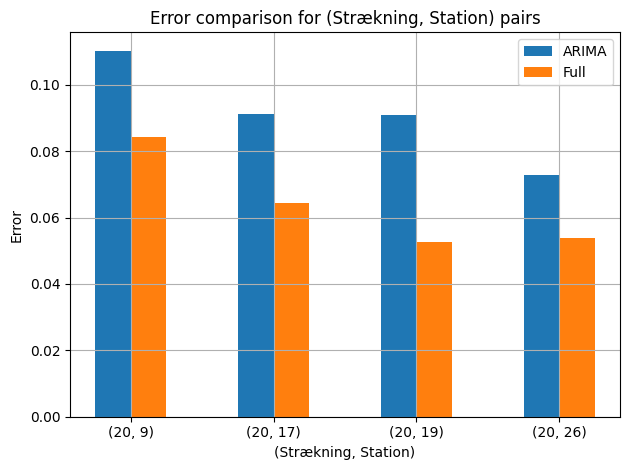

In [88]:
errors_Xgboost = pd.read_csv('Results/SARIMA_Xgboost_CV_errors_30.csv')
errors_Xgboost_20 = filter_errors(errors_Xgboost, 20)
error_plot(errors_Xgboost_20)

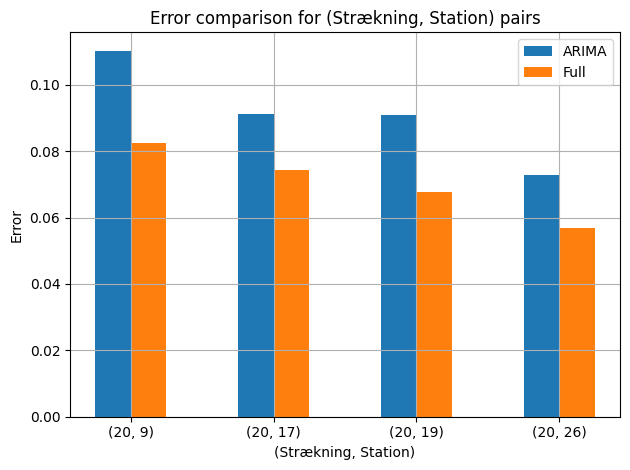

In [89]:
errors_Catboost = pd.read_csv('Results/SARIMA_Catboost_CV_errors_30.csv')
errors_Catboost_20 = filter_errors(errors_Catboost, 20)
error_plot(errors_Catboost_20)

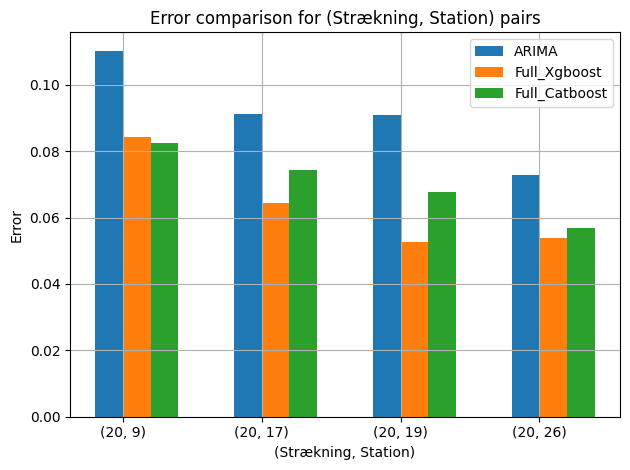

In [90]:
error_plot_together(errors_Xgboost_20, errors_Catboost_20)

# CV scores (Errors per data point)

In [21]:
# Plotting functions for each strækning
def hist_plot(strækning_station, cv_scores_full, cv_scores_arima):
    max_score = max(max(cv_scores_arima), max(cv_scores_full))
    min_score = min(min(cv_scores_arima), min(cv_scores_full))
    num_bins = 15
    bins = np.linspace(min_score, max_score, num_bins)
    
    plt.hist(cv_scores_arima, edgecolor = "black", bins=bins, label='ARIMA')
    plt.hist(cv_scores_full, edgecolor = "black", bins=bins, label='Full')
    plt.title(f'Strækning {strækning_station}')
    plt.xlabel('MAE')
    plt.ylabel('Occurences')
    plt.legend(loc='upper right')
    plt.grid()
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True)) # only integer ticks i y-axis
    #plt.savefig(f'Results/Strækning{strækning_station}_histogram_MAE_XGboost.png', bbox_inches='tight')
    plt.show()

def linechart_plot(strækning_station, cv_scores_full, cv_scores_arima):
    plt.plot(cv_scores_arima, label='ARIMA')
    plt.plot(cv_scores_full,label='Full')
    plt.title(f'Strækning {strækning_station}')
    plt.xlabel('Data points')
    plt.ylabel('MAE')
    plt.legend(loc='upper right')
    plt.grid()
    #plt.savefig(f'Results/Strækning{strækning_station}_linechart_MAE_XGboost.png', bbox_inches='tight')
    plt.show()

In [22]:
# only for kystbanen
def plot_cv_scores(cv_scores_dataframe, combinations, important_strækning):
    for strækning, station in combinations:
        if strækning == important_strækning:
            cv_scores_full = cv_scores_dataframe[str((int(strækning), int(station))) + '_full']
            cv_scores_arima = cv_scores_dataframe[str((int(strækning), int(station))) + '_arima']
            hist_plot((int(strækning), int(station)), cv_scores_full, cv_scores_arima)
            linechart_plot((int(strækning), int(station)), cv_scores_full, cv_scores_arima)

## Xgboost

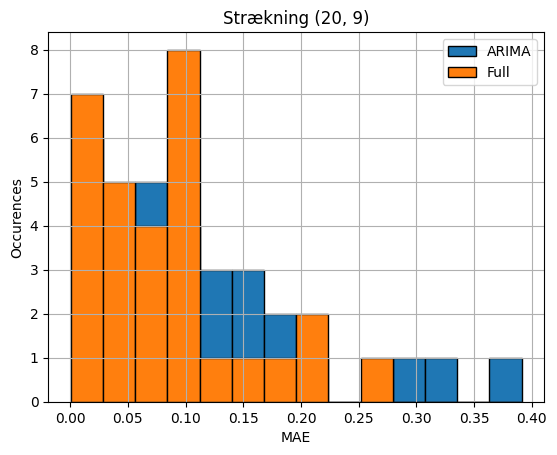

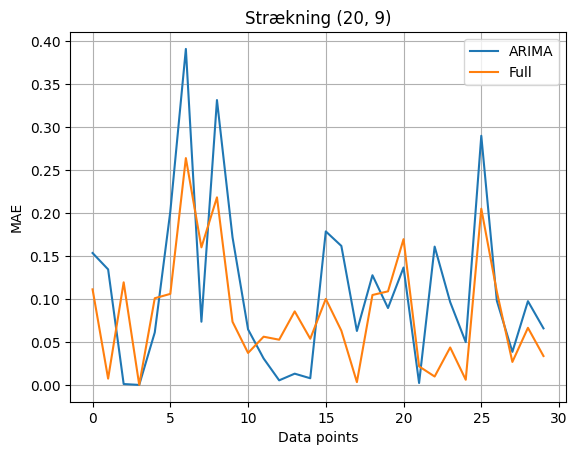

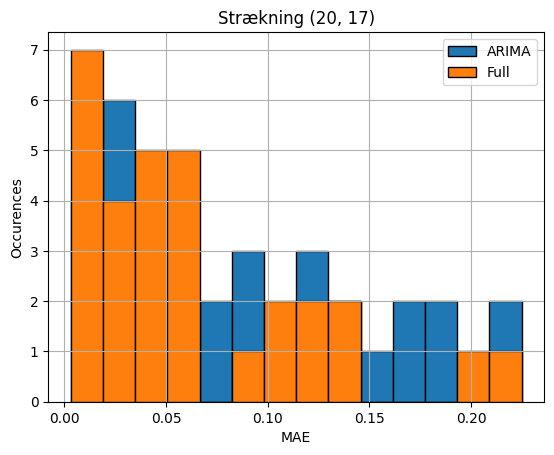

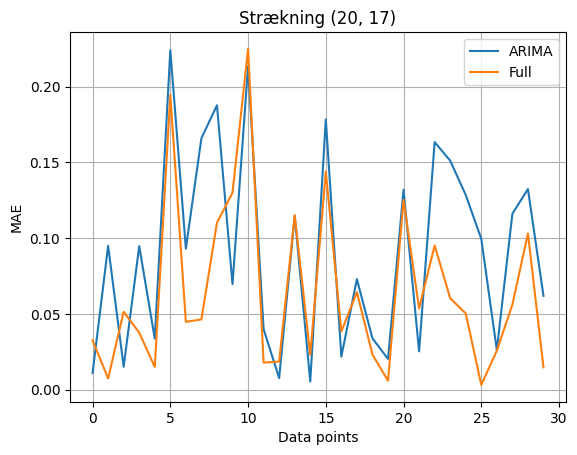

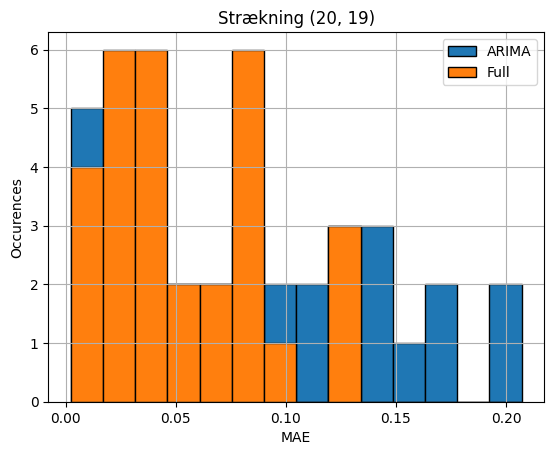

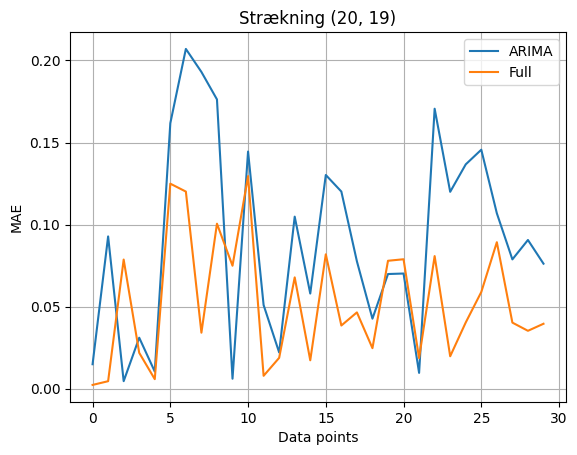

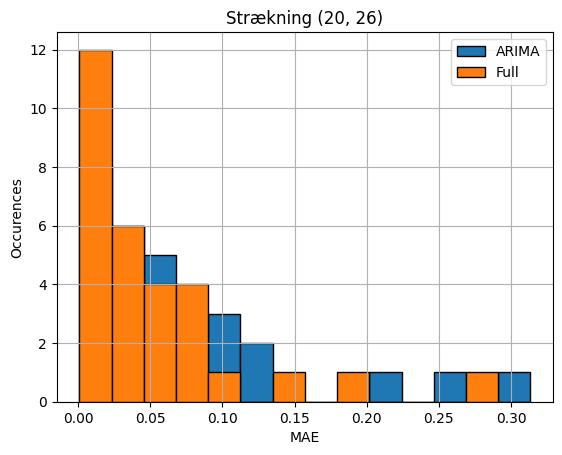

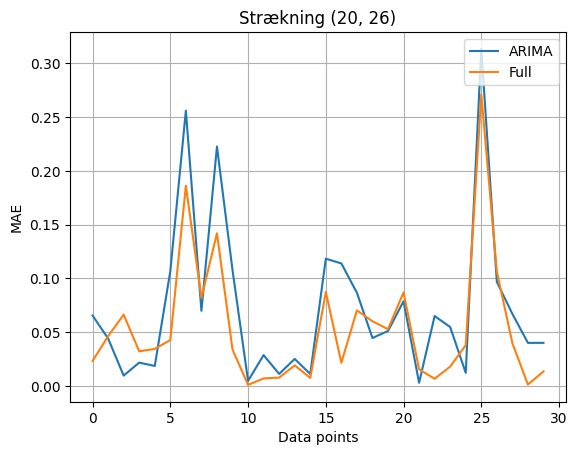

In [23]:
cv_scores_Xgboost = pd.read_csv('Results/SARIMA_Xgboost_CV_scores_30.csv')
cv_scores_Xgboost
plot_cv_scores(cv_scores_Xgboost, combinations, 20)

## Catboost

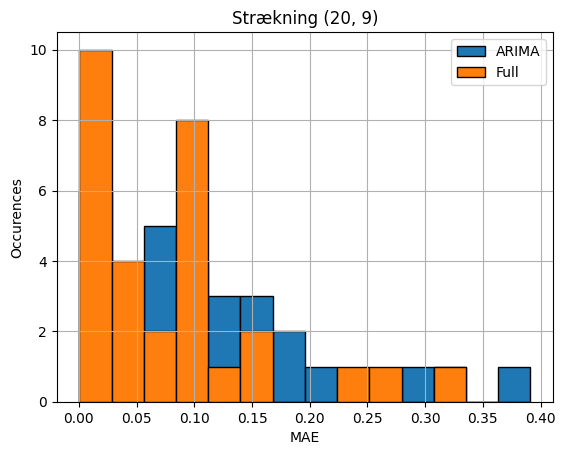

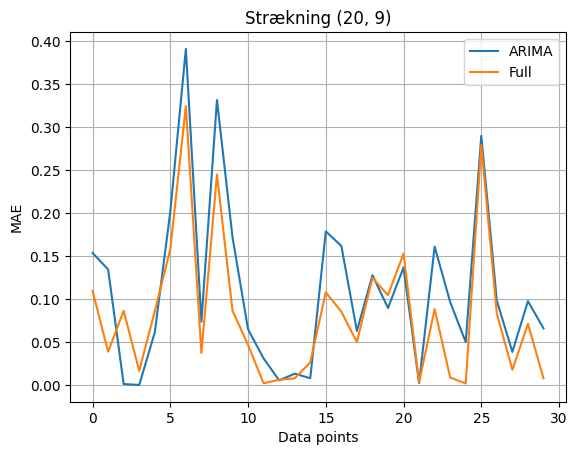

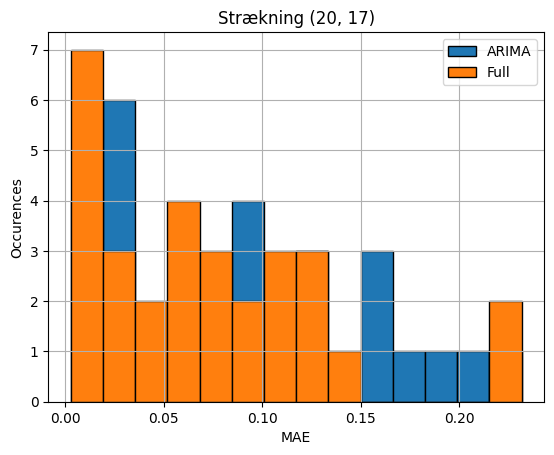

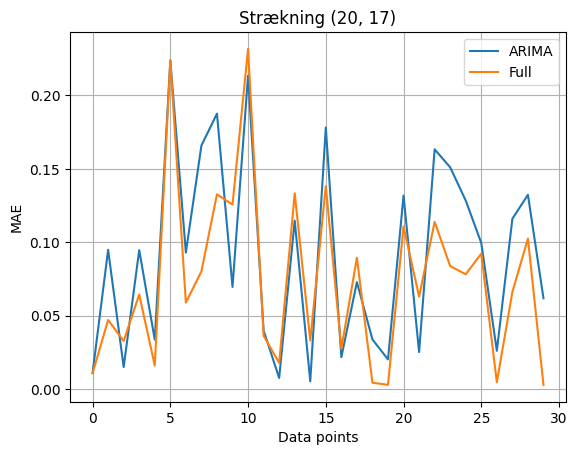

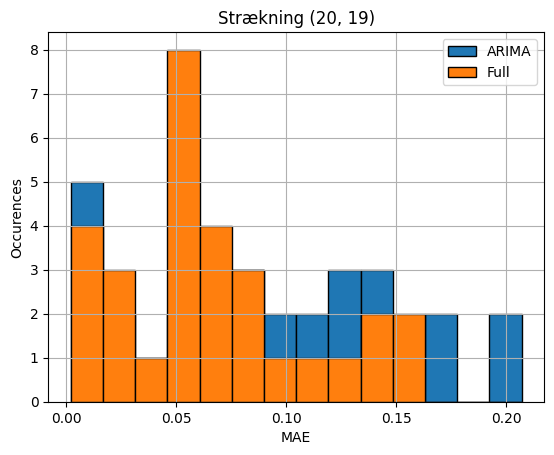

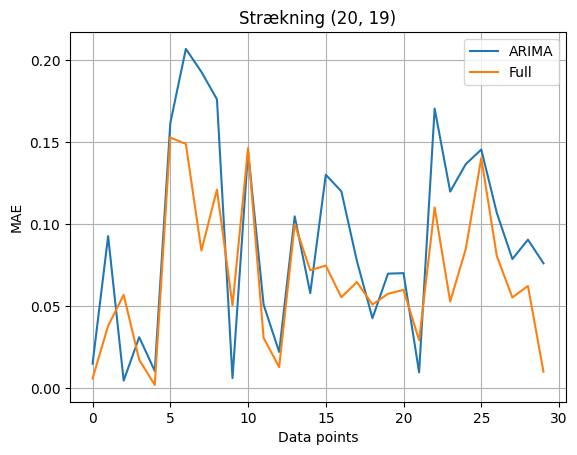

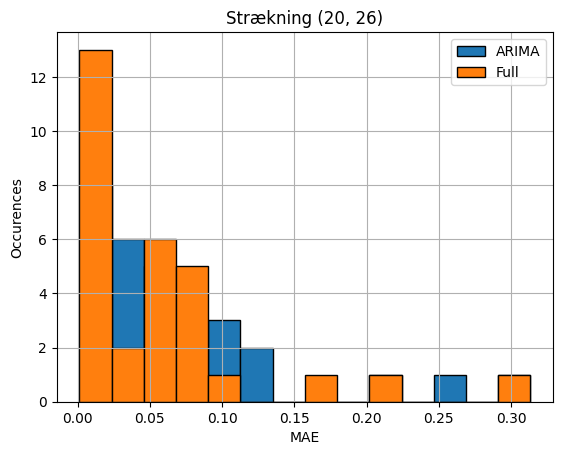

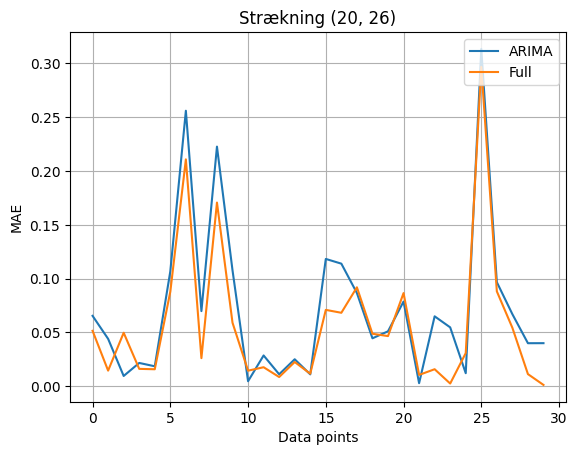

In [24]:
cv_scores_Catboost = pd.read_csv('Results/SARIMA_Catboost_CV_scores_30.csv')
cv_scores_Catboost
plot_cv_scores(cv_scores_Catboost, combinations, 20)

# Predictions

In [99]:
import ast
def filter_preds(dataframe, strækning):
    strækning_df = dataframe.filter(regex=f'^\({strækning}')
    strækning_station_combinations = set([ast.literal_eval(col.split('_')[0]) for col in strækning_df.columns])
    return strækning_df, strækning_station_combinations

def plot_preds(filtered_df, strækning_station_combinations, initial_start):
    initial_start = initial_start
    for strækning, station in strækning_station_combinations:
        y_test = data[(data['visualiseringskode'] == strækning) & (data['station'] == station)]['togpunktlighed'][-initial_start:]
        # Extract corresponding predictions from predictions DataFrame
        predictions_arima = filtered_df[f'({strækning}, {station})_arima']
        predictions_full = filtered_df[f'({strækning}, {station})_full']
        # Dates: 
        x_dates = data['dato'].iloc[y_test.index]

        plt.plot(x_dates, y_test, color='#33a02c', label='Test Data')
        plt.plot(x_dates, predictions_arima, color='#1E77B4', marker='x', label='ARIMA Predictions')
        plt.plot(x_dates, predictions_full, color='#FD7E0E', marker='x', label='Full Predictions')
        plt.title(f'Strækning {strækning}, station {station}: Predictions & True Value')
        plt.xlabel('Dates')
        plt.ylabel('Togpunktlighed')
        plt.xticks(x_dates[::5], rotation=45)
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

In [100]:
predictions_Catboost = pd.read_csv('Results/SARIMA_Catboost_CV_preds_30.csv')
predictions_Catboost

,"(1, 0)_arima","(1, 0)_full","(2, 0)_arima","(2, 0)_full","(1, 1)_arima","(1, 1)_full","(2, 2)_arima","(2, 2)_full","(9, 2)_arima","(9, 2)_full",...,"(8, 44)_arima","(8, 44)_full","(3, 45)_arima","(3, 45)_full","(5, 46)_arima","(5, 46)_full","(9, 46)_arima","(9, 46)_full","(25, 47)_arima","(25, 47)_full"
0,0.986104,0.998387,0.897276,0.942749,0.982080,0.979860,0.968407,1.000000,0.854349,0.789199,...,0.930712,0.942785,0.956399,0.982220,0.938625,0.975640,0.811060,0.789549,0.873850,0.890995
1,0.977017,0.993230,0.948420,0.985881,0.952377,0.941069,0.978904,1.000000,0.784281,0.826418,...,0.927933,0.965465,0.940673,0.982607,0.927089,0.986856,0.804602,0.744080,0.915044,0.963476
2,0.963835,0.982804,0.873358,0.928102,0.890411,0.905522,0.967761,1.000000,0.852589,0.894649,...,0.938460,0.975588,0.957778,1.000000,0.926327,0.970675,0.745214,0.742315,0.866206,0.912795
3,0.988171,1.000000,0.943629,0.988333,0.989716,1.000000,0.967794,1.000000,0.889157,0.905454,...,0.939147,0.954245,0.977428,0.994021,0.949455,0.957978,0.872073,0.884356,0.902003,0.932551
4,0.967884,0.980612,0.889711,0.932726,0.901043,0.911408,0.924756,0.955374,0.831881,0.835818,...,0.927537,0.902473,0.946594,0.968964,0.918529,0.946207,0.805691,0.827693,0.908272,0.903419
5,0.977904,0.985952,0.924329,0.970905,0.955156,0.966532,0.980619,1.000000,0.858858,0.888092,...,0.932947,0.945258,0.977205,0.995646,0.953006,0.981137,0.838676,0.857188,0.897442,0.919599
6,0.967588,0.977221,0.937959,0.941797,0.972735,0.978168,0.962988,0.967375,0.904739,0.935480,...,0.932553,0.943492,0.960967,0.928629,0.958139,0.988689,0.834836,0.853892,0.916100,0.896927
7,0.922172,0.910196,0.867545,0.878482,0.809686,0.810228,0.906213,0.918342,0.751682,0.713748,...,0.924645,0.931718,0.825762,0.844094,0.928103,0.951574,0.765120,0.764034,0.802396,0.753392
8,0.894158,0.911664,0.835496,0.884161,0.755424,0.769883,0.952518,0.992599,0.732050,0.786583,...,0.934459,0.971676,0.945915,0.983529,0.923832,0.973029,0.730958,0.777201,0.791212,0.842568
9,0.963566,0.977364,0.896783,0.944029,0.925129,0.948691,0.968737,1.000000,0.877869,0.899171,...,0.935290,0.970230,0.944778,0.982424,0.938433,0.976992,0.885336,0.907073,0.915981,0.966712


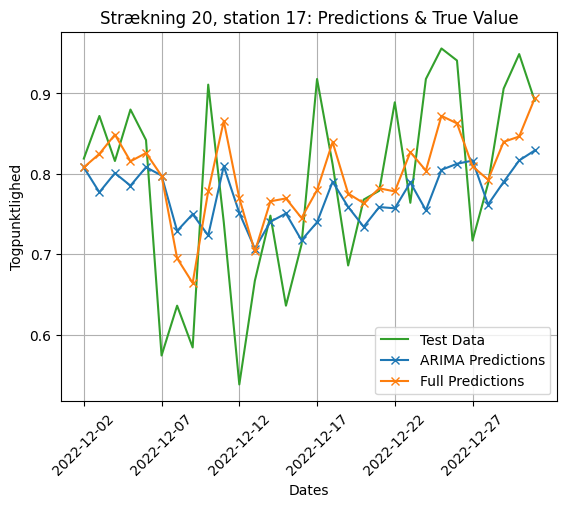

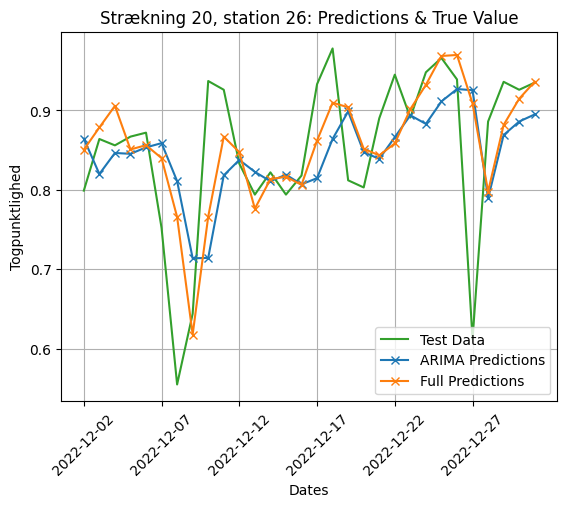

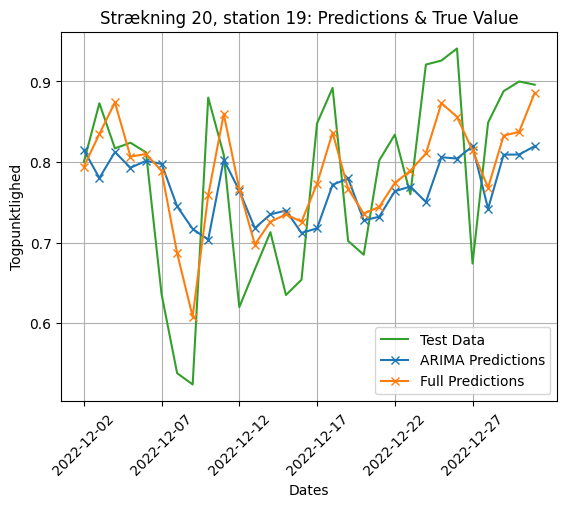

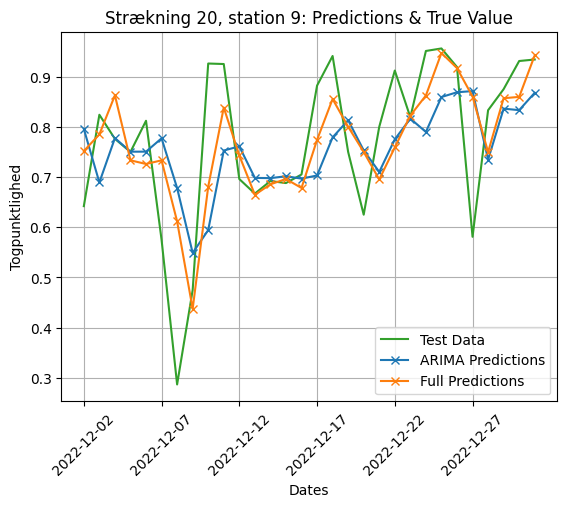

In [101]:
pred_Catboost_20, combinations_20 = filter_preds(predictions_Catboost, 20)
plot_preds(pred_Catboost_20, combinations_20, initial_start=30)

In [102]:
predictions_Xgboost = pd.read_csv('Results/SARIMA_Xgboost_CV_preds_30.csv')
predictions_Xgboost

,"(1, 0)_arima","(1, 0)_full","(2, 0)_arima","(2, 0)_full","(1, 1)_arima","(1, 1)_full","(2, 2)_arima","(2, 2)_full","(9, 2)_arima","(9, 2)_full",...,"(8, 44)_arima","(8, 44)_full","(3, 45)_arima","(3, 45)_full","(5, 46)_arima","(5, 46)_full","(9, 46)_arima","(9, 46)_full","(25, 47)_arima","(25, 47)_full"
0,0.986104,1.000000,0.897276,0.945332,0.982080,1.000000,0.968407,0.991990,0.854349,0.768349,...,0.930712,0.933720,0.956399,0.991042,0.938625,0.974209,0.811060,0.812678,0.873850,0.910527
1,0.977017,1.000000,0.948420,0.957422,0.952377,0.995893,0.978904,1.000000,0.784281,0.820066,...,0.927933,0.972573,0.940673,1.000000,0.927089,1.000000,0.804602,0.802751,0.915044,0.917242
2,0.963835,0.959741,0.873358,0.953011,0.890411,0.915953,0.967761,0.993738,0.852589,0.932456,...,0.938460,0.989963,0.957778,1.000000,0.926327,0.966768,0.745214,0.713872,0.866206,0.921189
3,0.988171,1.000000,0.943629,0.999588,0.989716,1.000000,0.967794,1.000000,0.889157,0.898360,...,0.939147,0.953553,0.977428,0.989500,0.949455,0.960890,0.872073,0.885454,0.902003,0.944239
4,0.967884,0.974555,0.889711,0.950163,0.901043,0.884562,0.924756,0.940851,0.831881,0.870935,...,0.927537,0.881119,0.946594,0.975643,0.918529,0.963562,0.805691,0.828867,0.908272,0.882521
5,0.977904,0.995076,0.924329,0.980715,0.955156,0.980629,0.980619,1.000000,0.858858,0.922330,...,0.932947,0.953832,0.977205,0.988874,0.953006,1.000000,0.838676,0.895401,0.897442,0.920113
6,0.967588,0.978800,0.937959,0.953736,0.972735,0.989633,0.962988,0.988440,0.904739,0.956418,...,0.932553,0.934211,0.960967,0.957195,0.958139,0.990413,0.834836,0.859543,0.916100,0.879586
7,0.922172,0.926663,0.867545,0.883030,0.809686,0.770820,0.906213,0.911531,0.751682,0.670637,...,0.924645,0.925247,0.825762,0.831819,0.928103,0.948437,0.765120,0.814561,0.802396,0.734381
8,0.894158,0.912836,0.835496,0.860505,0.755424,0.745985,0.952518,0.999815,0.732050,0.822101,...,0.934459,0.988433,0.945915,0.982275,0.923832,1.000000,0.730958,0.819971,0.791212,0.846800
9,0.963566,0.988479,0.896783,0.911183,0.925129,0.920668,0.968737,0.999239,0.877869,0.910857,...,0.935290,0.984723,0.944778,0.973789,0.938433,0.960205,0.885336,0.880422,0.915981,0.962632


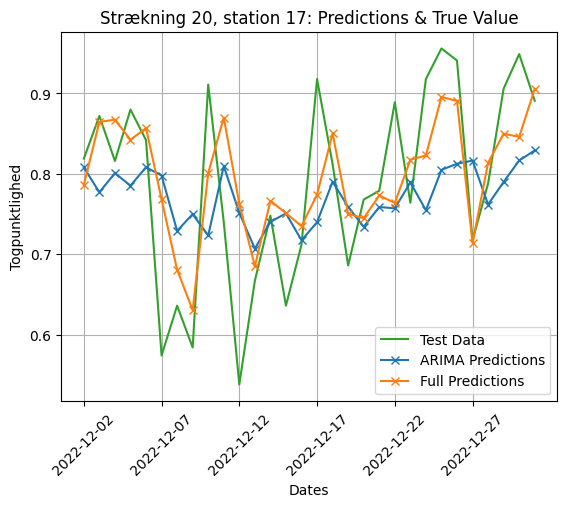

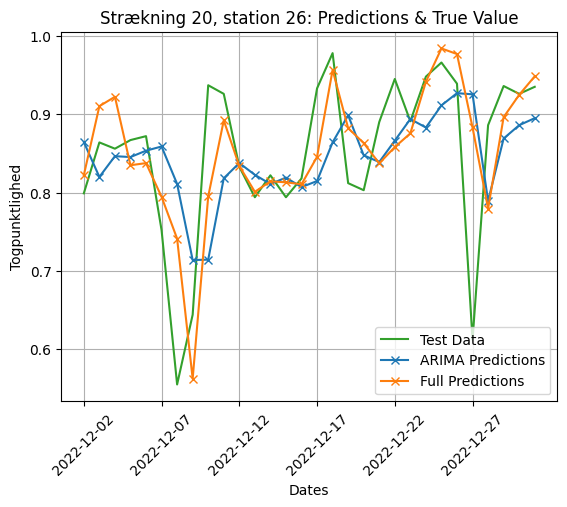

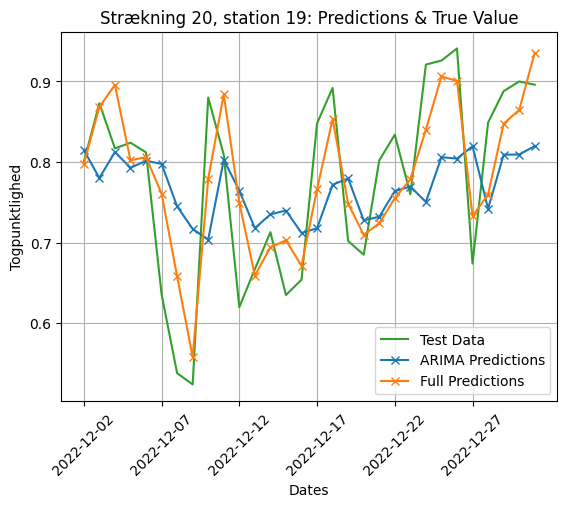

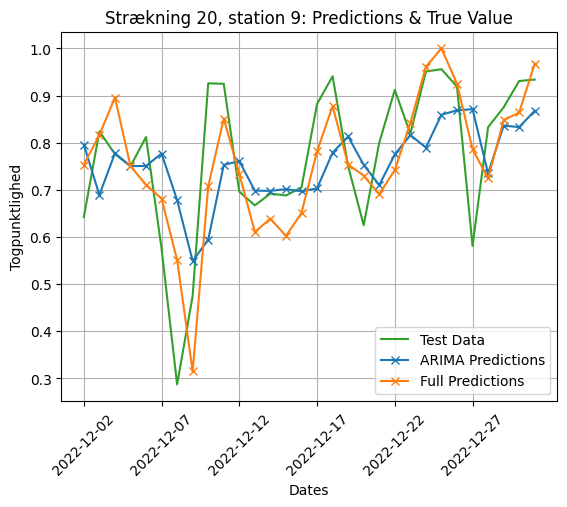

In [103]:
pred_Xgboost_20, combinations_20 = filter_preds(predictions_Xgboost, 20)
plot_preds(pred_Xgboost_20, combinations_20, initial_start=30)

# Feature importance